<a href="https://colab.research.google.com/github/MichelleAppel/Importance_sampling/blob/master/toy_example_with_discriminator_generator_batch_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling: toy example with parameters (batch method)
In this method we sample from a batch instead of one by one
Also a generator and discriminator network is added

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

Functions for generation and visualization of the image batches

In [0]:
def visualize_img_batch(batch):
    '''Visualizes image batch'''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [0]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Makes a random image batch of size (batch_size, height, width, channels) 
    with black to white ratio of value ratio
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])]
    image_batch = torch.zeros(size)
    
    image_batch[:, color] += offset # to make light gray
    image_batch[idx, color] = 1 - offset # to make dark gray 
    return image_batch

The dataset class

In [0]:
class ColorDataset(Dataset):
    '''The dataloader for the black and white images'''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # to make light color
        example_imgs[1, self.color] = 1 - self.offset # to make dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

The three networks

In [0]:
class WeightNet(nn.Module):

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.softmax(self.fc2(h1))
        return out

In [0]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(6, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 6)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [0]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

The two domains

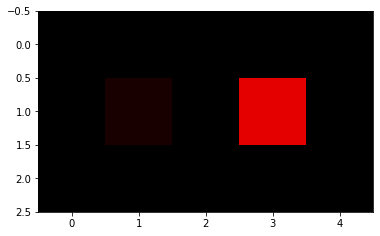

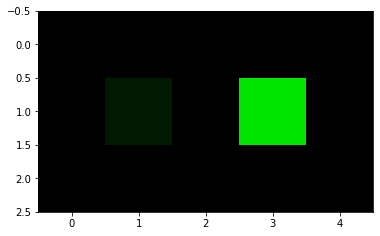

In [8]:
offset_A = 0.1
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

offset_B = 0.1
ratio_B = 0.7
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

In [0]:
def to_bool(image_batch):
    image_batch[image_batch < 0.5] = 0
    image_batch[image_batch > 0.5] = 1
    return image_batch

def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio:', x_unique_count/float(x_unique_count.sum()))
    plt.show()

True ratio: 0.5
Count: tensor([120, 136]) Ratio: tensor([0.4688, 0.5312])


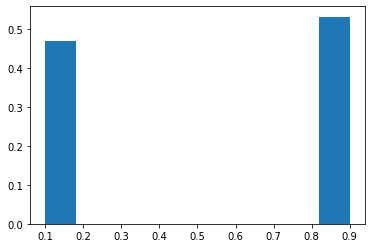

True ratio: 0.7
Count: tensor([ 74, 182]) Ratio: tensor([0.2891, 0.7109])


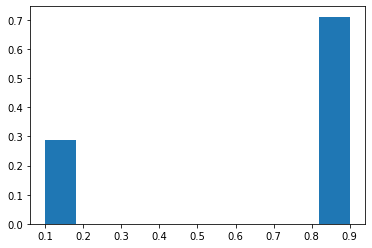

In [10]:
for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

In [11]:
weight_network_A = WeightNet()
weight_network_B = WeightNet()
generator_A = Generator()
generator_B = Generator()
discriminator = Discriminator()

optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=0.01)
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.01)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

sampled_batch_size = 64

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    optimizer_w.zero_grad()
    optimizer_d.zero_grad()
    optimizer_g.zero_grad()
    
    sm = nn.Softmax(dim=0)
    importances_A = sm(weight_network_A(data_A).squeeze()) # Get the importances for each image
    importances_B = sm(weight_network_B(data_B).squeeze()) # Get the importances for each image
    
    sampled_idx_A = list( # Sample according to these importances
        torch.utils.data.sampler.WeightedRandomSampler(importances_A,
                                                       sampled_batch_size, 
                                                       replacement=False))
    sampled_importances_A = importances_A[sampled_idx_A] # The importances assigned to the smaller batch
    real_A = data_A[sampled_idx_A] # The sampled smaller batch

    sampled_idx_B = list( # Sample according to these importances
        torch.utils.data.sampler.WeightedRandomSampler(importances_B,
                                                       sampled_batch_size, 
                                                       replacement=False))
    sampled_importances_B = importances_B[sampled_idx_B] # The importances assigned to the smaller batch
    real_B = data_B[sampled_idx_B] # The sampled smaller batch
    
    fake_A = generator_A(real_B)
    fake_B = generator_B(real_A)
    
    discriminated_A = discriminator(torch.cat((real_A, fake_B)))
    discriminated_B = discriminator(torch.cat((fake_A, real_B)))
    
    # The loss function:
    Lmin = (discriminated_A * sampled_importances_A/sampled_importances_A.detach()).sum()
    Lplus = (discriminated_B * sampled_importances_B/sampled_importances_B.detach()).sum()
    
    loss_g = Lmin - Lplus
    loss_w = (Lmin - Lplus)**2
    loss_d = Lplus - Lmin
    
    loss_w.backward(retain_graph=True)
    loss_g.backward(retain_graph=True)
    loss_d.backward()
 
    optimizer_w.step()
    optimizer_g.step()
    optimizer_d.step()

    Lminusses += [Lmin.item()]
    Lplusses += [Lplus.item()]
    
    losses_g += [loss_g.item()] # Store loss in a list
    losses_d += [loss_d.item()] # Store loss in a list
    losses_w += [loss_w.item()] # Store loss in a list
    
    w_a = weight_network_A(dataset_A.example_imgs)
    w_b = weight_network_B(dataset_B.example_imgs)
    example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
    example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
    
    # print statistics
    if i % 500 == 0:
        samples_A += [fake_A.detach()]
        samples_B += [fake_B.detach()]
        print('step', i, 'loss_g: ', loss_g.item(), 'loss_d: ', loss_d.item(), 'loss_w: ', loss_w.item())

step 0 loss_g:  0.197265625 loss_d:  -0.197265625 loss_w:  0.038913726806640625
step 500 loss_g:  -0.264404296875 loss_d:  0.264404296875 loss_w:  0.06990963220596313
step 1000 loss_g:  0.0361328125 loss_d:  -0.0361328125 loss_w:  0.0013055801391601562
step 1500 loss_g:  -0.017578125 loss_d:  0.017578125 loss_w:  0.000308990478515625
step 2000 loss_g:  0.01416015625 loss_d:  -0.01416015625 loss_w:  0.00020051002502441406
step 2500 loss_g:  -0.0009765625 loss_d:  0.0009765625 loss_w:  9.5367431640625e-07
step 3000 loss_g:  0.03662109375 loss_d:  -0.03662109375 loss_w:  0.001341104507446289
step 3500 loss_g:  -0.00048828125 loss_d:  0.00048828125 loss_w:  2.384185791015625e-07
step 4000 loss_g:  -0.0029296875 loss_d:  0.0029296875 loss_w:  8.58306884765625e-06
step 4500 loss_g:  -0.015869140625 loss_d:  0.015869140625 loss_w:  0.0002518296241760254
step 5000 loss_g:  -0.0203857421875 loss_d:  0.0203857421875 loss_w:  0.0004155784845352173
step 5500 loss_g:  0.0465087890625 loss_d:  -0.04

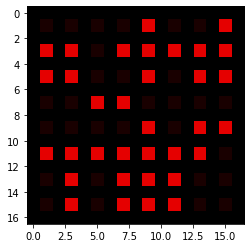

Count: tensor([30, 34]) Ratio: tensor([0.4688, 0.5312])


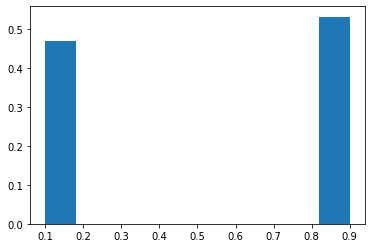

True ratio 0.5


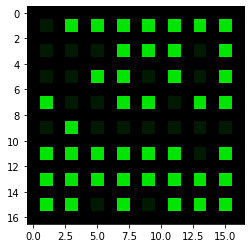

Count: tensor([22, 42]) Ratio: tensor([0.3438, 0.6562])


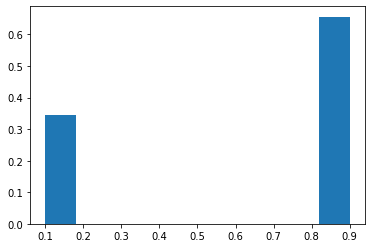

True ratio 0.7


In [12]:
visualize_img_batch(real_A)
plot_hist(real_A)
print('True ratio {}'.format(ratio_A))

visualize_img_batch(real_B)
plot_hist(real_B)
print('True ratio {}'.format(ratio_B))

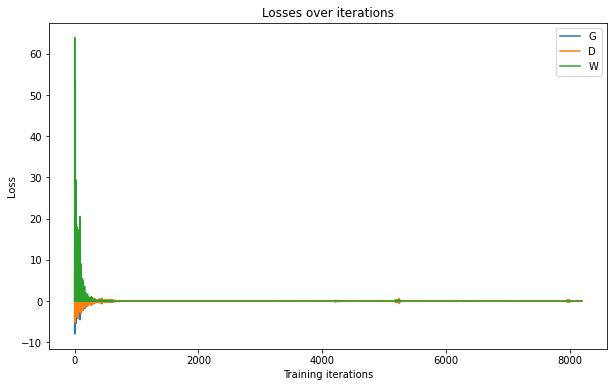

In [13]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.plot(losses_w)
plt.legend(['G', 'D', 'W'])
plt.show()

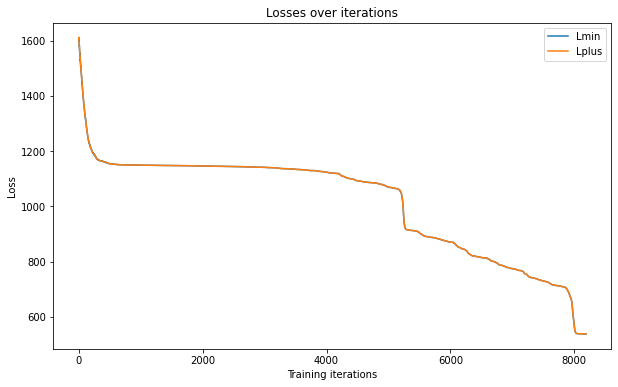

In [14]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

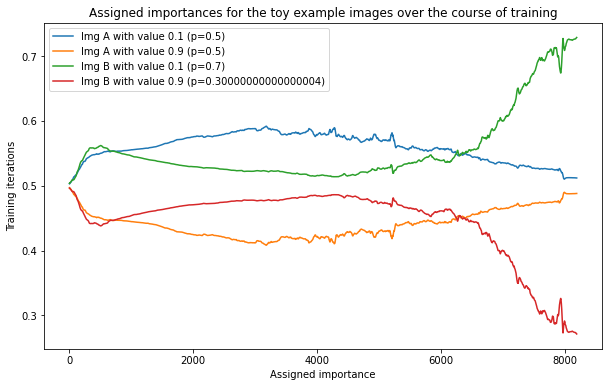

In [15]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()

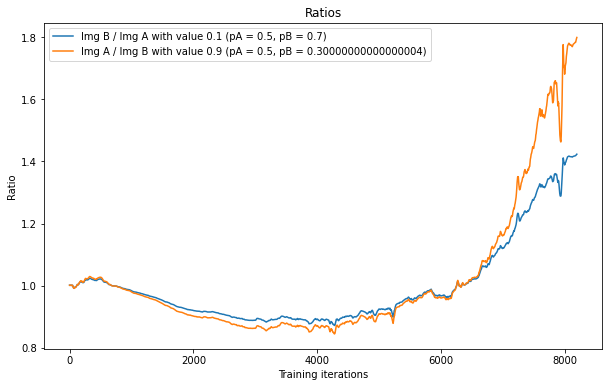

In [16]:
plt.figure(figsize=(10,6))
plt.title('Ratios')
ratio = (torch.tensor(example_importances_B) / torch.tensor(example_importances_A))[:, 0]
ratio_2 = 1 / (torch.tensor(example_importances_B) / torch.tensor(example_importances_A))[:, 1]
plt.plot(ratio)
plt.plot(ratio_2)
plt.legend(['Img B / Img A with value {} (pA = {}, pB = {})'.format(offset_B, ratio_A, ratio_B), 
            'Img A / Img B with value {} (pA = {}, pB = {})'.format(1-offset_A, 1-ratio_A, 1-ratio_B)])
plt.xlabel('Training iterations')
plt.ylabel('Ratio')
plt.show()